## Credit Risk Prediction 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
df = pd.read_csv("german_credit_data.csv")
print("Initial Dataset Shape:", df.shape)
display(df.head())

Initial Dataset Shape: (1000, 10)


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [3]:
#  Data Exploration
print(df.info())
print(df.describe(include='all'))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.3+ KB
None
         Unnamed: 0          Age   Sex          Job Housing Saving accounts  \
count   1000.000000  1000.000000  1000  1000.000000    1000             817   
unique          NaN          NaN     2          NaN       3               4   
top             NaN          NaN  male          N

In [4]:
df.drop(columns=['Unnamed: 0'], inplace=True)  # Drop index column if exists
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64


In [5]:
df['Saving accounts'] = df['Saving accounts'].fillna('no_info')  # Fill with 'no_info'
df['Checking account'] = df['Checking account'].fillna('no_info')  # Fill with 'no_info'

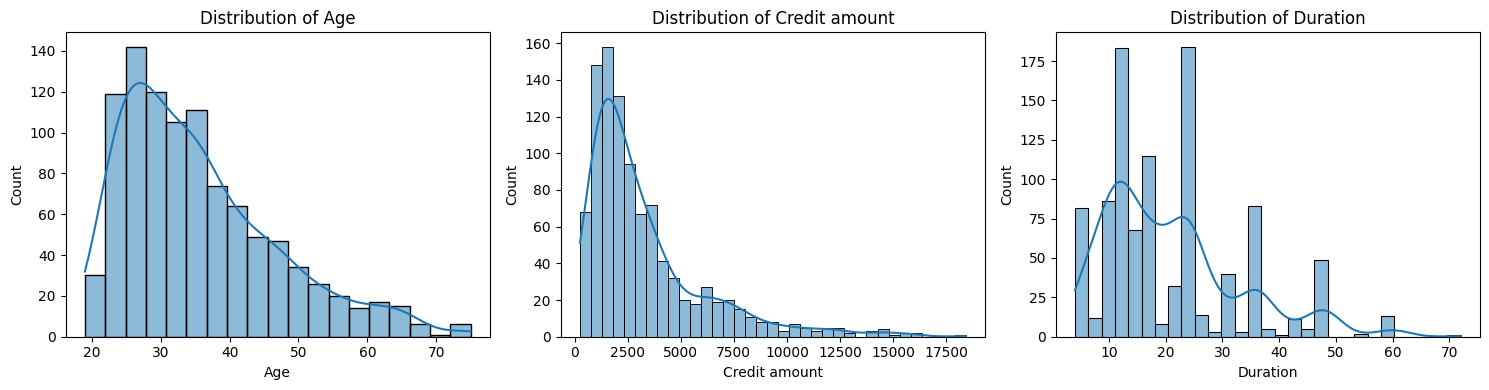

In [6]:
num_features = ['Age', 'Credit amount', 'Duration']
plt.figure(figsize=(15, 4))
for i, col in enumerate(num_features):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

In [ ]:
# Outlier Removal
from scipy import stats
z = np.abs(stats.zscore(df[['Age', 'Credit amount', 'Duration']]))
df = df[(z < 3).all(axis=1)]
print("Shape after removing outliers:", df.shape)

Shape after removing outliers: (958, 9)


In [ ]:
# Feature Engineering
df['Credit_per_month'] = df['Credit amount'] / df['Duration']
df['AgeGroup'] = pd.cut(df['Age'], bins=[18, 30, 50, 100], labels=['Young', 'Middle-aged', 'Senior'])
df['Target'] = (df['Credit amount'] < df['Credit amount'].median()).astype(int)  # 1=Good, 0=Bad

In [9]:
# Encode Categorical Features
categorical_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'AgeGroup']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [ ]:
#  Prepare Data for Modeling
X = df.drop(['Credit amount', 'Target'], axis=1)
y = df['Target']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [ ]:
# Model Training and Evaluation
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       142
           1       0.89      0.92      0.90       146

    accuracy                           0.90       288
   macro avg       0.90      0.90      0.90       288
weighted avg       0.90      0.90      0.90       288



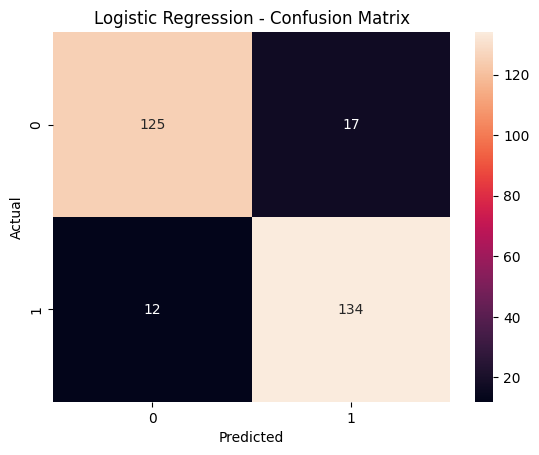


Random Forest Results:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       142
           1       0.95      0.92      0.93       146

    accuracy                           0.93       288
   macro avg       0.93      0.93      0.93       288
weighted avg       0.93      0.93      0.93       288



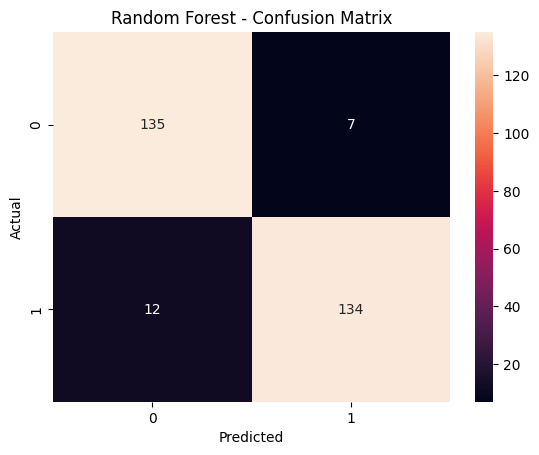


XGBoost Results:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       142
           1       0.97      0.96      0.97       146

    accuracy                           0.97       288
   macro avg       0.97      0.97      0.97       288
weighted avg       0.97      0.97      0.97       288



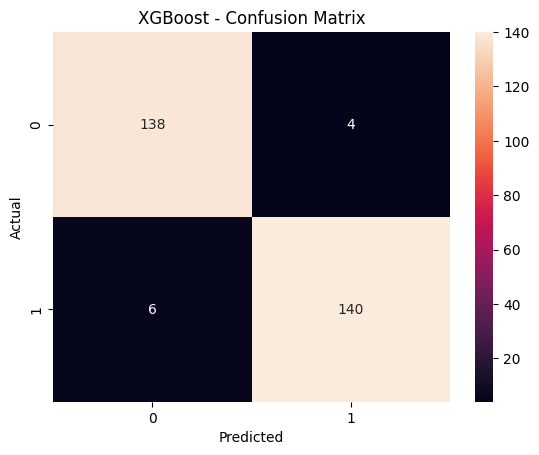

In [12]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [13]:
# Hyperparameter tuning example using GridSearchCV for XGBoost
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Perform GridSearchCV to tune hyperparameters
grid = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), 
                    param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)

# Output the best hyperparameters
print("Best Params for XGBoost:", grid.best_params_)


Best Params for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}


Model Evaluation Metrics on Test Set:
Accuracy : 0.9653
Precision: 0.9722
Recall   : 0.9589
F1 Score : 0.9655

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       142
           1       0.97      0.96      0.97       146

    accuracy                           0.97       288
   macro avg       0.97      0.97      0.97       288
weighted avg       0.97      0.97      0.97       288



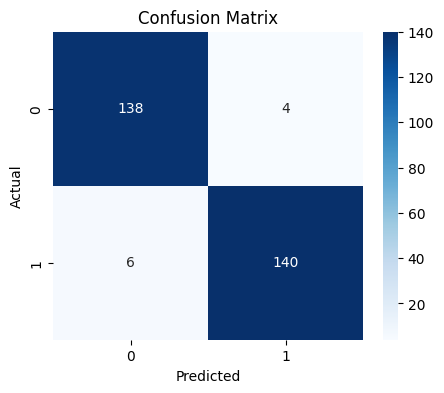

In [14]:
# Retrain the model with the best parameters from grid search
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
y_pred = model.predict(X_test)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display results
print("Model Evaluation Metrics on Test Set:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [15]:
import joblib
feature_names = X.columns.tolist()  # X is your training DataFrame
joblib.dump(feature_names, 'feature_names.pkl')


['feature_names.pkl']

In [16]:
import joblib

# Save the trained model
joblib.dump(best_model, 'credit_risk_model.pkl')

# Save the scaler (if you want to use the same preprocessing for new data)
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [17]:
model = joblib.load('credit_risk_model.pkl')  # ✅ Loads your saved, trained model
scaler = joblib.load('scaler.pkl')            # ✅ Loads the saved scaler used during training


In [22]:
import joblib
import pandas as pd

# Load the trained model
model = joblib.load('credit_risk_model.pkl')

# Example input data (you can replace this with real user input)
input_data = {
    'Age': [30],
    'Credit amount': [2000],
    'Duration': [24],
    'Credit_per_month': [2000 / 24],  # calculated feature
    'AgeGroup_Senior': [0],  # based on Age
    'AgeGroup_Young': [1],   # based on Age
    'Sex_male': [1],         # based on user input (example: "male")
    'Housing_own': [1],      # based on user input (example: "own")
    'Housing_rent': [0],     # based on user input (example: "rent")
    'Saving accounts_moderate': [0],  # based on user input (example: "moderate")
    'Saving accounts_no_info': [0],   # based on user input (example: "no_info")
    'Saving accounts_quite rich': [0], # based on user input (example: "quite rich")
    'Saving accounts_rich': [1],       # based on user input (example: "rich")
    'Checking account_moderate': [1],  # based on user input (example: "moderate")
    'Purpose_car': [0],                # based on user input (example: "car")
    # Add other necessary columns from the training data
}

# Convert the input data to a DataFrame
input_df = pd.DataFrame(input_data)

# Ensure the input data has the same columns as the model
# Use the feature_names variable to ensure the input data matches the model's expected features
for col in feature_names:
    if col not in input_df.columns:
        input_df[col] = 0
input_df = input_df[feature_names]

# Make the prediction (without scaling)
prediction = model.predict(input_df)

# Display the result
if prediction == 1:
    print(" Good Credit Risk")
else:
    print(" Bad Credit Risk")


 Bad Credit Risk
